In [1]:
# Cell 1: Environment & GPU Setup
!nvidia-smi
!nvcc --version


Wed Apr 23 22:32:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
# Cell 2 (Extended): Generate multi-attribute synthetic Twitter dataset
import pandas as pd
import numpy as np
import cupy as cp

np.random.seed(42)
n_rows = 1_000_000

tweets_df = pd.DataFrame({
    "tweet_id": np.arange(n_rows),
    "retweet_count": np.random.exponential(scale=100, size=n_rows).astype(np.float32),
    "like_count": np.random.exponential(scale=150, size=n_rows).astype(np.float32),
    "reply_count": np.random.exponential(scale=30, size=n_rows).astype(np.float32),
})

print("Sample rows:\n", tweets_df.head())


Sample rows:
    tweet_id  retweet_count  like_count  reply_count
0         0      46.926807  135.637878     3.221265
1         1     301.012146   68.052742    10.626773
2         2     131.674576    0.808518    30.365194
3         3      91.294258  123.518356    17.163532
4         4      16.962486  340.329620     7.476069


In [17]:
# Cell 2a: Transfer selected attribute to GPU
def get_attribute_gpu(attr_name: str) -> cp.ndarray:
    assert attr_name in tweets_df.columns, f"{attr_name} not found in dataset!"
    return cp.array(tweets_df[attr_name].values)


In [18]:
# Cell 2b: Compute custom weighted score and move to GPU
def get_custom_score_gpu(weights: dict) -> cp.ndarray:
    score = sum(
        weights.get(col, 0.0) * tweets_df[col].values.astype(np.float32)
        for col in weights if col in tweets_df.columns
    )
    return cp.array(score)


In [3]:
# Cell 3: Raw kernel test – multiply each element by 10
x = cp.arange(8, dtype=cp.int32)

kernel_code = r'''
extern "C" __global__
void multiply_by_ten(int* arr) {
    int tid = threadIdx.x;
    arr[tid] = arr[tid] * 10;
}
'''

module = cp.RawModule(code=kernel_code)
kernel = module.get_function('multiply_by_ten')
kernel((1,), (8,), (x,))

print("After kernel execution:", cp.asnumpy(x))


After kernel execution: [ 0 10 20 30 40 50 60 70]


In [4]:
# Cell 4: Sorting-Based Top-K on full dataset
import time

K = 100  # You can change this value as needed

# Step 1: Copy data to avoid modifying original
data_gpu = retweet_gpu.copy()

# Step 2: Sort on GPU (descending) and measure time
start = time.time()
sorted_gpu = cp.sort(data_gpu)[::-1]
cp.cuda.Device(0).synchronize()
end = time.time()

# Step 3: Extract Top-K
topk_gpu = sorted_gpu[:K]
topk_host = cp.asnumpy(topk_gpu)

# Step 4: Output
print(f"Total GPU sorting time: {(end - start) * 1000:.2f} ms")
print("Top-K retweet counts:")
print(topk_host)


Total GPU sorting time: 62.73 ms
Top-K retweet counts:
[1329.3662  1219.2137  1213.0828  1184.3812  1174.1371  1164.6904
 1151.6266  1145.7673  1145.3226  1124.5924  1124.4691  1112.2103
 1107.9725  1104.3782  1098.1399  1094.4607  1094.0759  1091.7228
 1091.5646  1078.3514  1071.8934  1071.4209  1063.6384  1063.4977
 1059.7777  1052.1228  1048.8583  1039.3384  1028.6422  1027.1
 1024.0319  1023.9408  1021.0011  1019.7633  1017.6089  1007.3306
 1005.32495 1001.7093   994.2706   992.38196  988.382    987.1576
  986.87225  981.0891   978.9859   975.6035   974.085    973.05457
  972.7743   972.5752   971.61127  971.5177   966.98914  966.957
  965.7075   965.0747   962.64343  959.35504  957.5388   956.8962
  956.76855  956.37225  955.4164   954.609    953.95135  952.8828
  952.74896  952.51624  951.3408   949.5716   946.95917  946.88513
  946.0384   945.1353   944.9902   942.6288   941.99164  939.1416
  938.2068   937.12177  936.8722   935.06134  935.00903  932.59705
  932.47064  932.3362 

In [5]:
# Cell 5: Bitonic Sort Demo (8 elements)
bitonic_code = r'''
extern "C" __global__
void bitonic_sort(float* data) {
    __shared__ float sdata[8];
    int tid = threadIdx.x;
    sdata[tid] = data[tid];

    __syncthreads();

    for (int k = 2; k <= 8; k <<= 1) {
        for (int j = k >> 1; j > 0; j >>= 1) {
            int ixj = tid ^ j;
            if (ixj > tid) {
                if ((tid & k) == 0) {
                    if (sdata[tid] > sdata[ixj]) {
                        float tmp = sdata[tid];
                        sdata[tid] = sdata[ixj];
                        sdata[ixj] = tmp;
                    }
                } else {
                    if (sdata[tid] < sdata[ixj]) {
                        float tmp = sdata[tid];
                        sdata[tid] = sdata[ixj];
                        sdata[ixj] = tmp;
                    }
                }
            }
            __syncthreads();
        }
    }

    data[tid] = sdata[tid];
}
'''

# Compile and test the kernel
mod = cp.RawModule(code=bitonic_code)
bitonic_sort = mod.get_function('bitonic_sort')

# Sample input
data = cp.random.rand(8, dtype=cp.float32)
print("Before:", cp.asnumpy(data))

# Launch kernel: 1 block, 8 threads
bitonic_sort((1,), (8,), (data,))

print("After: ", cp.asnumpy(data))


Before: [0.5408896  0.5092592  0.6096782  0.1458138  0.358811   0.4722119
 0.87102944 0.01342577]
After:  [0.01342577 0.1458138  0.358811   0.4722119  0.5092592  0.5408896
 0.6096782  0.87102944]


In [6]:
# Cell 6: Bitonic Sort for 1024 elements
bitonic_large_code = r'''
extern "C" __global__
void bitonic_sort_1024(float* data) {
    __shared__ float sdata[1024];
    int tid = threadIdx.x;

    // Load global to shared memory
    sdata[tid] = data[tid];
    __syncthreads();

    // Bitonic sorting network
    for (int k = 2; k <= 1024; k <<= 1) {
        for (int j = k >> 1; j > 0; j >>= 1) {
            int ixj = tid ^ j;
            if (ixj > tid) {
                if ((tid & k) == 0) {
                    if (sdata[tid] > sdata[ixj]) {
                        float tmp = sdata[tid];
                        sdata[tid] = sdata[ixj];
                        sdata[ixj] = tmp;
                    }
                } else {
                    if (sdata[tid] < sdata[ixj]) {
                        float tmp = sdata[tid];
                        sdata[tid] = sdata[ixj];
                        sdata[ixj] = tmp;
                    }
                }
            }
            __syncthreads();
        }
    }

    data[tid] = sdata[tid];
}
'''

# Compile and test kernel
mod = cp.RawModule(code=bitonic_large_code)
bitonic_sort_1024 = mod.get_function('bitonic_sort_1024')

# Create 1024 random floats
data = cp.random.rand(1024, dtype=cp.float32)
print("Before (first 10):", cp.asnumpy(data[:10]))

# Launch kernel: 1 block, 1024 threads
bitonic_sort_1024((1,), (1024,), (data,))

# Copy result back and check sort correctness
sorted_result = cp.asnumpy(data)
print("After  (first 10):", sorted_result[:10])
print("Sorted? ", all(sorted_result[i] <= sorted_result[i+1] for i in range(1023)))


Before (first 10): [0.08937991 0.7517578  0.462388   0.61359745 0.48263192 0.9500375
 0.23723918 0.901046   0.45848748 0.41337878]
After  (first 10): [0.00129121 0.00293565 0.0031898  0.00352625 0.00428911 0.00502005
 0.00783561 0.01132349 0.01238468 0.01355972]
Sorted?  True


In [7]:
# Cell 7: Bitonic Sort + Top-K Extraction (K = 100)
import time

K = 100
N = 1024  # Must be power of 2, matching kernel logic

bitonic_code = r'''
extern "C" __global__
void bitonic_sort_1024(float* data) {
    __shared__ float sdata[1024];
    int tid = threadIdx.x;

    sdata[tid] = data[tid];
    __syncthreads();

    for (int k = 2; k <= 1024; k <<= 1) {
        for (int j = k >> 1; j > 0; j >>= 1) {
            int ixj = tid ^ j;
            if (ixj > tid) {
                if ((tid & k) == 0) {
                    if (sdata[tid] > sdata[ixj]) {
                        float tmp = sdata[tid];
                        sdata[tid] = sdata[ixj];
                        sdata[ixj] = tmp;
                    }
                } else {
                    if (sdata[tid] < sdata[ixj]) {
                        float tmp = sdata[tid];
                        sdata[tid] = sdata[ixj];
                        sdata[ixj] = tmp;
                    }
                }
            }
            __syncthreads();
        }
    }

    data[tid] = sdata[tid];
}
'''

# Compile kernel
mod = cp.RawModule(code=bitonic_code)
bitonic_sort_1024 = mod.get_function('bitonic_sort_1024')

# Generate data
data = cp.random.rand(N, dtype=cp.float32)

# Run kernel and time it
start = time.time()
bitonic_sort_1024((1,), (1024,), (data,))
cp.cuda.Device(0).synchronize()
end = time.time()

# Extract top-K from sorted array (ascending → reverse slice)
topk = cp.asnumpy(data[-K:][::-1])

# Output
print(f"Bitonic sort + top-{K} extraction time: {(end - start) * 1000:.2f} ms")
print("Top-K values:")
print(topk)


Bitonic sort + top-100 extraction time: 0.17 ms
Top-K values:
[0.99805313 0.9952894  0.99520457 0.9946547  0.9935725  0.99343544
 0.9928719  0.9912497  0.99103314 0.99098766 0.9902803  0.9898628
 0.9896533  0.98922795 0.98919237 0.98892033 0.98861694 0.98518455
 0.98206055 0.9819148  0.9814257  0.98098403 0.97954434 0.9784784
 0.97790796 0.97719955 0.97638875 0.9757652  0.9756986  0.97464484
 0.9745503  0.97452176 0.97408956 0.97354513 0.9726024  0.97087854
 0.97054493 0.9703686  0.9667752  0.96664125 0.9646557  0.9645977
 0.96394557 0.96371603 0.9626877  0.9605061  0.96034986 0.9599403
 0.95801    0.95752823 0.95624465 0.9562235  0.95616245 0.9542114
 0.94989586 0.94766563 0.93976194 0.9389458  0.9381577  0.93765193
 0.9359596  0.9350546  0.93393403 0.93384933 0.93319535 0.93210095
 0.9286525  0.9268838  0.9260975  0.92424995 0.9221031  0.92191625
 0.92128134 0.91968083 0.9183063  0.91824555 0.91594976 0.91572696
 0.9147885  0.9146255  0.91446334 0.9142143  0.91409653 0.9131775
 0.912

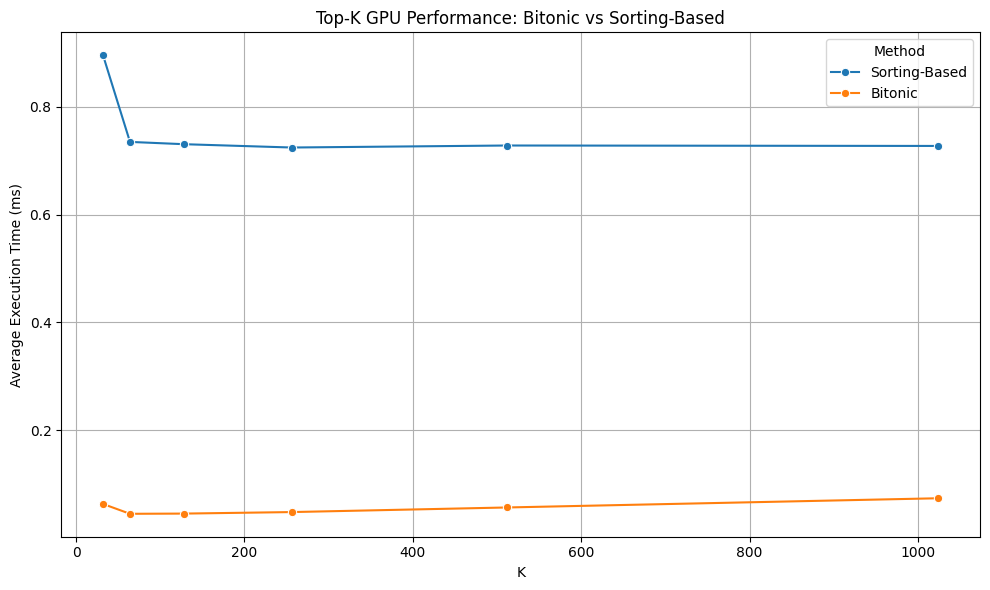

       K         Method  Avg Time (ms)
0     32  Sorting-Based       0.895214
1     32        Bitonic       0.063515
2     64  Sorting-Based       0.734615
3     64        Bitonic       0.045300
4    128  Sorting-Based       0.730371
5    128        Bitonic       0.045681
6    256  Sorting-Based       0.724220
7    256        Bitonic       0.048494
8    512  Sorting-Based       0.727940
9    512        Bitonic       0.057030
10  1024  Sorting-Based       0.727129
11  1024        Bitonic       0.074100


In [19]:
# Cell 8: Benchmark Sorting-Based vs Bitonic Top-K on chosen GPU data
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Select target: either a single attribute or a composite score
# Option 1: attribute_gpu = get_attribute_gpu("like_count")
# Option 2: attribute_gpu = get_custom_score_gpu({"retweet_count": 0.5, "like_count": 0.3, "reply_count": 0.2})
attribute_gpu = get_attribute_gpu("reply_count")  # 👈 CHANGE HERE

k_values = [32, 64, 128, 256, 512, 1024]
trials = 5
results = []

for K in k_values:
    sort_times, bitonic_times = [], []

    for _ in range(trials):
        # Sorting-based Top-K
        data = attribute_gpu.copy()
        start = time.time()
        sorted_data = cp.sort(data)[::-1]
        topk = sorted_data[:K]
        cp.cuda.Device(0).synchronize()
        end = time.time()
        sort_times.append((end - start) * 1000)

        # Bitonic-based Top-K
        data = attribute_gpu[:K].copy()
        start = time.time()
        bitonic_sort((1,), (K,), (data, K), shared_mem=K * 4)
        cp.cuda.Device(0).synchronize()
        topk_b = data[-K:][::-1]
        end = time.time()
        bitonic_times.append((end - start) * 1000)

    results.append({"K": K, "Method": "Sorting-Based", "Avg Time (ms)": np.mean(sort_times)})
    results.append({"K": K, "Method": "Bitonic", "Avg Time (ms)": np.mean(bitonic_times)})

# Results DataFrame
df = pd.DataFrame(results)

# Plot results
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="K", y="Avg Time (ms)", hue="Method", marker="o")
plt.title("Top-K GPU Performance: Bitonic vs Sorting-Based")
plt.xlabel("K")
plt.ylabel("Average Execution Time (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(df)


In [10]:
# Cell 10: Define Merge and Rebuild kernels for full Bitonic Top-K
merge_code = r'''
extern "C" __global__
void bitonic_merge(float* input, float* output, int K) {
    int tid = threadIdx.x;
    int bid = blockIdx.x;
    int offset = bid * K * 2 + tid;

    float a = input[offset];
    float b = input[offset + K];
    output[bid * K + tid] = max(a, b);
}
'''

rebuild_code = r'''
extern "C" __global__
void bitonic_rebuild(float* data, int K) {
    extern __shared__ float sdata[];
    int tid = threadIdx.x;
    sdata[tid] = data[tid];
    __syncthreads();

    for (int len = K >> 1; len > 0; len >>= 1) {
        int ixj = tid ^ len;
        if (ixj > tid) {
            if ((tid & K) == 0) {
                if (sdata[tid] > sdata[ixj]) {
                    float tmp = sdata[tid];
                    sdata[tid] = sdata[ixj];
                    sdata[ixj] = tmp;
                }
            } else {
                if (sdata[tid] < sdata[ixj]) {
                    float tmp = sdata[tid];
                    sdata[tid] = sdata[ixj];
                    sdata[ixj] = tmp;
                }
            }
        }
        __syncthreads();
    }

    data[tid] = sdata[tid];
}
'''

# Compile kernels
merge_mod = cp.RawModule(code=merge_code)
rebuild_mod = cp.RawModule(code=rebuild_code)

bitonic_merge = merge_mod.get_function("bitonic_merge")
bitonic_rebuild = rebuild_mod.get_function("bitonic_rebuild")


In [11]:
# Cell 11: Full Bitonic Top-K Pipeline
def run_bitonic_topk(input_data, K):
    N = len(input_data)
    assert N % K == 0, "Data size must be divisible by K"
    num_blocks = N // K

    # Step 1: Local bitonic sort on each K-sized block
    for i in range(num_blocks):
        ptr = input_data[i*K:(i+1)*K]
        bitonic_sort((1,), (K,), (ptr, K), shared_mem=K*4)

    current = input_data

    # Step 2+: Recursively merge and rebuild
    while current.size > K:
        num_merges = current.size // (2 * K)
        merged = cp.empty(num_merges * K, dtype=cp.float32)

        # Merge each adjacent pair of K-blocks
        bitonic_merge((num_merges,), (K,), (current, merged, K))

        # Rebuild each merged block
        for i in range(num_merges):
            ptr = merged[i*K:(i+1)*K]
            bitonic_rebuild((1,), (K,), (ptr, K), shared_mem=K*4)

        current = merged

    return cp.asnumpy(current[::-1])  # Return top-K in descending order


In [12]:
# Cell 12: Execute Full Bitonic Top-K on 1M tweets
import time

K = 100
retweet_gpu_copy = retweet_gpu.copy()

start = time.time()
topk_bitonic = run_bitonic_topk(retweet_gpu_copy, K)
cp.cuda.Device(0).synchronize()
end = time.time()

# Sort for pretty output
topk_bitonic = np.sort(topk_bitonic)[::-1]

# Output results
print(f"Bitonic Top-{K} runtime: {(end - start) * 1000:.2f} ms")
print("Top-K retweet counts (Bitonic, sorted):")
print(topk_bitonic)


Bitonic Top-100 runtime: 215.63 ms
Top-K retweet counts (Bitonic, sorted):
[1329.3662   1219.2137    856.968     781.83026   644.0742    602.9194
  538.7124    520.47845   461.47742   451.56387   430.8945    409.7405
  406.46463   385.40155   380.85278   365.49765   354.82193   343.31458
  325.2804    292.68262   286.28088   281.41806   270.333     269.18817
  262.3197    254.00693   250.3256    239.42603   223.56775   221.1654
  213.27838   209.43185   209.28522   200.00978   199.64973   197.9465
  196.40709   182.82358   179.07112   173.18811   170.57089   165.28783
  160.01637   154.46896   152.1096    150.25627   150.24393   148.83948
  141.12898   139.35274   135.89296   134.54172   131.09027   124.03999
  123.15321   122.57136   112.52305   109.79638   103.75849    99.679245
   98.31574    97.60823    97.21144    94.71031    93.47808    92.68465
   89.861946   85.58572    85.16368    82.04566    79.29637    75.040764
   70.66674    69.63944    67.235085   66.45002    65.3787     

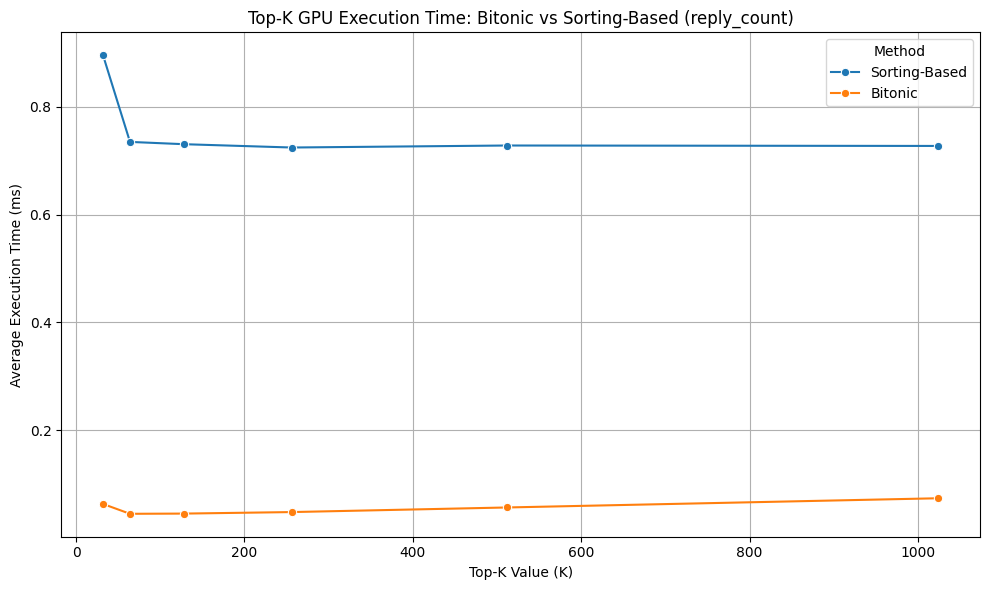

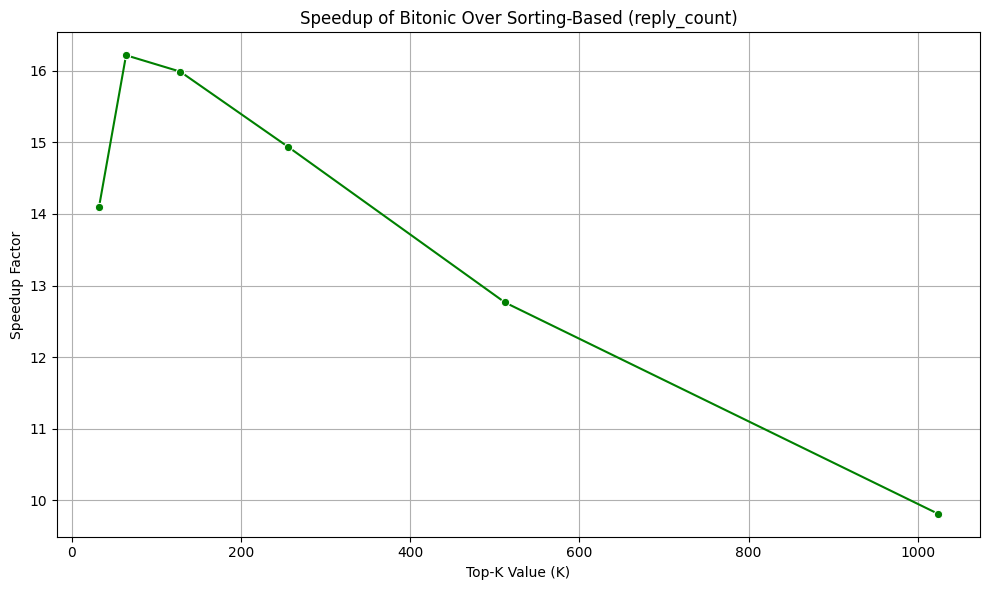

In [20]:
# Cell 13: Speedup of Bitonic over Sorting-Based
df_pivot = df.pivot(index='K', columns='Method', values='Avg Time (ms)')
df_pivot['Speedup'] = df_pivot['Sorting-Based'] / df_pivot['Bitonic']

# Plot: Execution Time vs K
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="K", y="Avg Time (ms)", hue="Method", marker="o")
plt.title("Top-K GPU Execution Time: Bitonic vs Sorting-Based (reply_count)")
plt.xlabel("Top-K Value (K)")
plt.ylabel("Average Execution Time (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Speedup vs K
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_pivot.index, y=df_pivot['Speedup'], marker='o', color='green')
plt.title("Speedup of Bitonic Over Sorting-Based (reply_count)")
plt.xlabel("Top-K Value (K)")
plt.ylabel("Speedup Factor")
plt.grid(True)
plt.tight_layout()
plt.show()
